# <center>Анализ алгоритма<a style='color:red'> FaceNet </a> 

___
<a id=100>Содержание</a>
- [Ключевые особенности алгоритма](#1)
- [Основные этапы алгоритма](#2)
    - [Архитектура нейронной сети](#3)
    - [Функция потерь Triplet Loss](#4)
- [Пример использования](#5)
- [Преимущества и недостатки FaceNet](#6)



___
## <center><a id=1 style='color:red'>Ключевые особенности алгоритма</a>

`FaceNet` - алгоритм, который может использоваться для  задач верификации, распознавания и кластеризации лиц. При помощи нейронных сетей изображения лиц преобразуются в компактное евклидово пространство, где расстояния
напрямую соответствуют мере сходства лиц.

`FaceNet` использует архитектуру сиамской нейронной сети, которая состоит из `трех` идентичных подсетей:
- Нейронная сеть, в которую подают изображение  лица, которое принимается за `положительный` класс
- Нейронная сеть, в которую подают изображение `якорного` лица, совпадающего с лицом, отнесенным к положительному классу
- Нейронная сеть, в которую подают изображение  лица, которое не относится к положительному классу - `отрицательный` класс

`Структура FaceNet`:

<img src='data/img/facenet_cnn.jpg' width=700>

В качестве функции потерь используется `triplet loss`, которая минимизирует евклидово расстояние между векторными представлениями одного и того же объекта и максимизирует расстояние между разными объектами.



___
## <center><a id=2 style='color:red'>Основные этапы алгоритма</a>

#### $\boxed{\text{Нейронная сеть}} \rightarrow \boxed{\text{L2 нормализация}} \rightarrow \boxed{\text{Эмбеддинг}} \rightarrow \boxed{\text{Triplet loss}}$

### <center><a id=3 >1. Архитектура нейронной сети</a>

Для получения эмбеддингов лиц может использоваться множество архитектур сверточных нейронных сетей. Например, в оригинальной статье [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832.pdf) рассматриваются нейронные сети:
- Inception
- Zeiler&Fergus

### Архитектура <a>Inception</a>:

<img src='data/img/inseption.png'>

В `Inseption блоках` выполняются различные виды сверток и затем конкатенируются:

<img src='data/img/incept.png' width=600>


Ключевые особенности архитектуры Inception, используемой в FaceNet:
- Использование $L_2$- пулинга вместо max-пулинга:
    - для каждого окна пулинга рассчитывается $L_2$-норма для всех элементов, попавших в окно:
        - $\boxed{L_2 = \sqrt{x_1^2 + x_2^2 + ... + x_n^2}}$, где
            - $x_1, x_2, ..., x_n$ — элементы слоя, попавшие в окно пулинга $x$

- Пулинг всегда имеет размер $3 \times 3$

### Архитектура <a>Zeiler&Fergus</a>:

<img src='data/img/ferg.png'>

Точность результата Zeiler&Fergus меньше, чем у Inception, но ресурсозатратность намного ниже

### <center><a id=4 >2. Функция потерь Triplet Loss</a>

На выходе из нейронных сетей получаются `128-мерные` `нормированные` векторные представления якорного лица, положительного класса и не относящегося к положительному классу лица:

- $f(x_i^a) \in R^{128}$: `якорное` изображение
- $f(x_i^p) \in R^{128}$: `позитивный` класс
- $f(x_i^n) \in R^{128}$: `негативный` класс

    - $\boxed{||f(x_i^a)||_2 = ||f(x_i^p)||_2 = ||f(x_i^n)||_2 = 1 }$

Для вычисления функции потерь рассчитываются расстояния:

- Между `якорным` изображением и изображением `позитивного` класса, т.е. между лицами одного и того же объекта:

    - $\boxed{ ||f(x_i^a) - f(x_i^p) ||_2^2 }$

- Между `якорным` изображением и изображением `негативного` класса, т.е. между лицами разных объектов:

    - $\boxed{ ||f(x_i^a) - f(x_i^n) ||_2^2 }$

Функция потерь Triplet Loss принемаеь вид:
- $\boxed{Triplet \ Loss =  \sum_i^N \Big[ ||f(x_i^a) - f(x_i^p) ||_2^2 - ||f(x_i^a) - f(x_i^n) ||_2^2 + \alpha \Big]_+ }$, где

    - $\Big[ value \Big]_+ = \max(value, 0)$
    - $\alpha$ : расстояние между парами объектов позитивного и негативного класса

При минимизации функции потерь расстояние между объектами одного класса будет уменьшаться, а расстояние между объектами отличных классов - увеличиваться. Будет выполняться условие:

- $\boxed{ ||f(x_i^a) - f(x_i^p) ||_2^2 + \alpha < ||f(x_i^a) - f(x_i^n) ||_2^2  }$


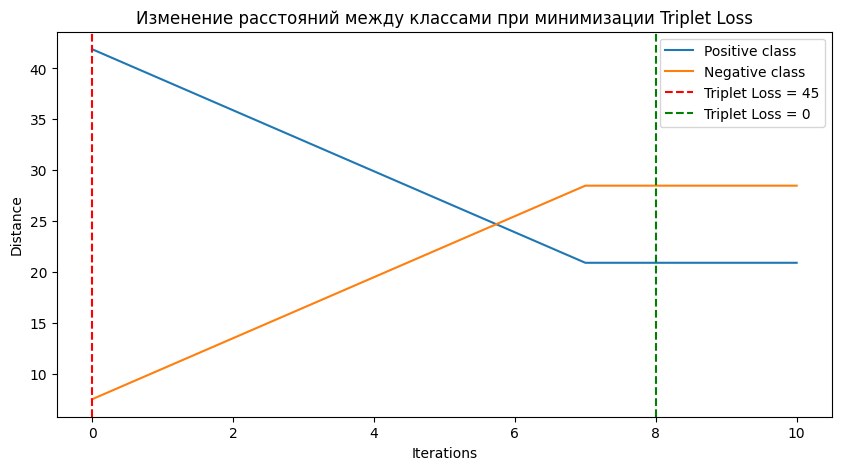

In [102]:
import torch
from torch.nn.modules.distance import PairwiseDistance
import matplotlib.pyplot as plt

anchor = torch.tensor((1.,2.,3.,4.,5.))
positive = torch.tensor((10.,20.,30.,20.,30.), requires_grad=True)
negative = torch.tensor((1.,2.,1.,4.,9.), requires_grad=True)

l2_distance = PairwiseDistance(p=2)
lr = 3
alpha = 5
pos_dist = []
neg_dist = []
for i in range(11):
    loss_func = torch.mean(torch.clamp(l2_distance(anchor, positive) - l2_distance(anchor, negative) + alpha, min=0))
    loss_func.backward()
    negative.data -= lr * negative.grad
    positive.data -= lr * positive.grad
    negative.grad.zero_()
    positive.grad.zero_()
    pos_dist.append(l2_distance(anchor, positive).item())
    neg_dist.append(l2_distance(anchor, negative).item())

plt.figure(figsize=(10,5))
plt.plot(pos_dist, label='Positive class')
plt.plot(neg_dist, label='Negative class')
plt.axvline(0, c='r', linestyle='--', label='Triplet Loss = 45')
plt.axvline(8, c='g', linestyle='--', label='Triplet Loss = 0')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Distance');
plt.title('Изменение расстояний между классами при минимизации Triplet Loss');

___
## <center><a id=5 style='color:red'>Пример использования</a>

- `Загрузка изображения`

- `Инициализация MTCNN`
- `Инициализация InceptionResnetV1`

In [134]:
from facenet_pytorch import MTCNN, InceptionResnetV1

mtcnn = MTCNN()
resnet = InceptionResnetV1(pretrained='vggface2').eval()

from PIL import Image
import os

db_path_p = 'data/Aaron_Eckhart/'
db_path_n = 'data/Aaron_Guiel/'
img_names_p = list(os.walk(db_path_p))[0][2]
img_names_n = list(os.walk(db_path_n))[0][2]
img_path_1 = db_path_p + img_names_p[0]
img_path_2 = db_path_p + img_names_p[1]
img_path_3 = db_path_n + img_names_n[0]

img_1 = Image.open(img_path_1)
img_2 = Image.open(img_path_2)
img_3 = Image.open(img_path_3)

- `Детектирование лиц`

- `Создание эмбеддингов`

- `Расчет расстояний между объектами`

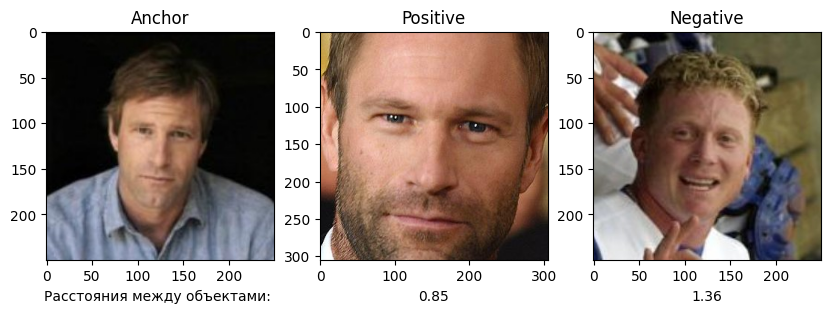

In [140]:
img_cropped_1 = mtcnn(img_1)
img_cropped_2 = mtcnn(img_2)
img_cropped_3 = mtcnn(img_3)

img_embedding_1 = resnet(img_cropped_1.unsqueeze(0))
img_embedding_2 = resnet(img_cropped_2.unsqueeze(0))
img_embedding_3 = resnet(img_cropped_3.unsqueeze(0))

positive_dist = torch.norm(img_embedding_1 - img_embedding_2).item()
negative_dist = torch.norm(img_embedding_1 - img_embedding_3).item()

fig, ax = plt.subplots(1,3, figsize=(10,4))
ax[0].imshow(img_1)
ax[0].set_title('Anchor')
ax[0].set_xlabel('Расстояния между объектами: ')

ax[1].imshow(img_2)
ax[1].set_title('Positive')
ax[1].set_xlabel(f'{positive_dist:.2f}')

ax[2].imshow(img_3)
ax[2].set_title('Negative');
ax[2].set_xlabel(f'{negative_dist:.2f}');

___
## <center><a id=6 style='color:red'>Преимущества и недостатки FaceNet</a>

<center><a>Преимущества</a></center>

- `Высокая точность`: FaceNet обладает высокой точностью распознавания лиц, что делает его эффективным инструментом для аутентификации и идентификации.

- `Масштабируемость`: FaceNet может обрабатывать большое количество изображений и лиц, что делает его подходящим для использования в больших системах.
- `Быстродействие`: FaceNet работает быстро, что позволяет использовать его в реальном времени для аутентификации пользователей.
- `Универсальность`: FaceNet можно использовать для различных задач, связанных с распознаванием лиц, таких как поиск по фотографиям, обнаружение лиц и т. д.
- `Открытый исходный код`: FaceNet является открытым проектом, что позволяет другим разработчикам использовать его и вносить свой вклад в его развитие.

<center><a>Недостатки</a></center>

- `Зависимость от данных`: FaceNet требует большого количества данных для обучения.

- `Необходимость настройки`: FaceNet требует настройки параметров и обучения на конкретных данных, что может занять время и ресурсы.




___
## <center><a id=9 style='color:red'>Использованные источники</a>

| Ссылка|Краткое описание |
|-|-| 
| [FaceNet GitHub](https://github.com/davidsandberg/facenet)| Tensorflow имплементация FaceNet |
| [FaceNet-pytorch GitHub](https://github.com/timesler/facenet-pytorch)|Pytorch имплементация FaceNet |
|[FaceNet Wikipedia](https://en.wikipedia.org/wiki/FaceNet) | Описание FaceNet|
|[FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832.pdf) | Статья о  FaceNet |
| [FaceNet: Универсальный эмбеддинг для распознавания и кластеризации лиц](https://habr.com/ru/articles/731020/)|Статья о  FaceNet (перевод) |
|[Presentation by Ignacio Aranguren and Rahul Rana](http://llcao.net/cu-deeplearning17/pp/class10_FaceNet.pdf) |Презентация FaceNet|
| [Реализация функции потерь Triplet Loss в Python (функция тройных потерь)](https://habr.com/ru/articles/737060/)|Описание Triplet Loss |
| [Метрическое обучение с использованием сиамских и триплетных сверточных нейронных сетей](https://skine.ru/articles/232251/)| Описание Triplet Loss|
|[Метрическое обучение с использованием сиамских и триплетных сверточных нейронных сетей](https://skine.ru/articles/232251/) | Описание Triplet Loss|